In [1]:
import matplotlib.pyplot as plt
import math as m
import numpy as np  # 1.7 or higher
from ipywidgets import interactive
from IPython.display import display



import qgrid
import pandas as pd

import sympy as sym
sym.init_printing(order="none")
from sympy.vector import CoordSys3D
import sympy.vector as symvec


np.set_printoptions(suppress=True, formatter={'float_kind':'{:14.4f}'.format})  
%matplotlib inline

#  jupyter nbconvert --no-input --to pdf RotorHead.ipynb 

In [2]:
 def Eq(expr1, expr2):
    return sym.Eq(expr1, expr2, evaluate=False)

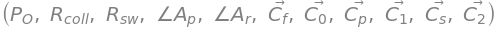

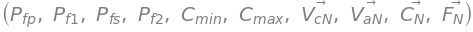

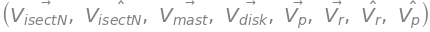

In [13]:
P0 = sym.Symbol(r'P_O');  #Origin of XYZ system
Rcoll = sym.Symbol(r'R_{coll}') #height of collective above origin
Rsw = sym.Symbol(r'R_{sw}') #radius of swashplate arms from P_coll

Ap = sym.Symbol(r'\angle{A_p}') #pitch angle
Ar = sym.Symbol(r'\angle{A_r}') #roll angle
Acyl = sym.Symbol(r'\angle{A_{cyl}}') # cylinder spacing


Cf, C0 = sym.symbols(r'\vec{C_f},\vec{C_0}') 
Cp, C1 = sym.symbols(r'\vec{C_p},\vec{C_1}')
Cs, C2 = sym.symbols(r'\vec{C_s},\vec{C_2}')

# Front linear actuator, vector representing length
Ff, F0 = sym.symbols(r'\vec{F_f},\vec{F_0}') 
Fp, F1 = sym.symbols(r'\vec{F_p},\vec{F_1}') #Port linear actuator
Fs, F2 = sym.symbols(r'\vec{F_s},\vec{F_2}') #Starboard linear actuator

Vmast = sym.symbols(r'\vec{V_{mast}}')
Vdisk = sym.symbols(r'\vec{V_{disk}}')

Visectn, Visectnhat = sym.symbols(r'\vec{V_{isectN}},\hat{V_{isectN}}')
Vcn, Cn, Fn= sym.symbols(r'\vec{V_{cN}},\vec{C_N},\vec{F_N}')
Van, Pfn = sym.symbols(r'\vec{V_{aN}}, P_{fn}')

Paf, Pa0 = sym.symbols(r'P_a_f,P_a_0') #End of front swashplate arm
Pap, Pa1 = sym.symbols(r'P_a_p,P_a_1') #End of port swashplate arm
Pas, Pa2 = sym.symbols(r'P_a_s,P_a_2') #End of starboard swashplate arm

Pff, Pf0 = sym.symbols(r'P_f_f,P_f_0') #End of front swashplate foot
Pfp, Pf1 = sym.symbols(r'P_f_p,P_f_1') #End of port swashplate foot
Pfs, Pf2 = sym.symbols(r'P_f_s,P_f_2') #End of starboard swashplate foot

# cylinder minimum length, cylinder maximum length
Cmin, Cmax = sym.symbols("C_m_i_n C_m_a_x")

#Pitch vector from cyclic, Roll vector from cyclic
Vp, Vr = sym.symbols(r'\vec{V_p} \vec{V_r}')
Vrhat = sym.Symbol(r'\hat{V_r}') #unit vector versons of above
Vphat = sym.Symbol(r'\hat{V_p}')

display((P0, Rcoll, Rsw, Ap, Ar, Cf, C0, Cp, C1, Cs, C2))
display((Paf, Pa0, Pap, Pa1, Pas, Pa2, Pff, Pf0, Pfn))
display((Pfp, Pf1, Pfs, Pf2, Cmin, Cmax, Vcn, Van, Cn, Fn))
display((Visectn, Visectnhat, Vmast, Vdisk,  Vp, Vr, Vrhat, Vphat))

In [7]:

e1 = Eq(Vp, sym.Matrix([sym.cos(Ap), 0, sym.sin(Ap)]).T)
e2 = Eq(Vphat, Vp/abs(Vp))

e3 = Eq(Vr, sym.Matrix([0, sym.cos(Ar), sym.sin(Ar)]).T)
e4 = Eq(Vrhat, Vr/abs(Vr))

e5 = Eq(Ff, sym.Matrix([Rsw, 0, 0]).T)
e6 = Eq(Fp, sym.Matrix([Rsw*sym.sin(Acyl), Rsw*sym.cos(Acyl), 0]).T)
e7 = Eq(Fs, sym.Matrix([Rsw*sym.sin(2*Acyl), Rsw*sym.cos(2*Acyl), 0]).T)

e8 = Eq(Vmast, sym.Matrix([0, 0, Rcoll]).T)

# order is important here
e9 = Eq(Vdisk, symvec.Cross(Vphat, Vrhat))

# for each cylinder, Vcn normal of plane formed by foot and mast
e9_5 = Eq(Fn, Pfn-P0)
e10 = Eq(Vcn, symvec.Cross(Fn, Vmast))
e11 = Eq(Visectn, symvec.Cross(Vdisk, Vcn))
e12 = Eq(Visectnhat, Visectn/abs(Visectn))
e13 = Eq(Van, Rsw*Visectnhat+Vmast)
e14 = Eq(Cn, Van - Fn)

eqs = [e1, e2, e3, e4, e5, e6, e7, e8, e9] 
eqs2 = [e9_5, e10, e11, e12, e13, e14]
for i, e in enumerate(eqs):
    #display(e)
    display((sym.Symbol(f"{i+1}"),e))
    
display("Then, for every Cylinder")
display(Cn)

for i, e in enumerate(eqs2):
    #display(e)
    display((sym.Symbol(f"{i+10}"),e))


(1, \vec{V_p} = [cos(\angle{A_p})  0  sin(\angle{A_p})])

(3, \vec{V_r} = [0  cos(\angle{A_r})  sin(\angle{A_r})])

(5, \vec{F_f} = [R_{sw}  0  0])

(6, \vec{F_p} = [R_{sw}⋅sin(\angle{A_{cyl}})  R_{sw}⋅cos(\angle{A_{cyl}})  0])

(7, \vec{F_s} = [R_{sw}⋅sin(2⋅\angle{A_{cyl}})  R_{sw}⋅cos(2⋅\angle{A_{cyl}}) 
 0])

(8, \vec{V_{mast}} = [0  0  R_{coll}])

'Then, for every Cylinder'

In [5]:
#for e in eqs:
#    print(sym.latex(e))

### Algorithm

The point Pcoll is first chosen from the collective input.  The pitch vector Vp is the x axis rotated
around the y axis by the pitch input.  The roll vector Vr is the y axis rotated along the x axis by
the roll input.

The normal vector representing the plane of the rotor then Vr X Vx.

Then for each of the cylinder, the Mast X the vector from the orgin to the foot of the cylinder
is normal to the plane the cylinder can travel in.  The cross product of this vector and the rotor
plane vector is the vector of intersection of these two planes.  This vector is normalized and then
multiplied by radius R and added to Pc to locate the top point of the cylinder.

Finally, the length of the cylinder vector is checked to make sure it fits within the limits.